In [1]:
import requests 
import json 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import time
from glob import glob
import numpy as np
import os
import pickle
import statsmodels.api as sm
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
from scripts import utility

In [2]:
alldata = pd.read_hdf(r'C:\Users\Administrator\Nutstore\1\WMLakefund\data\pv_data\binance\alldata_hourly.hdf')

### universe

<AxesSubplot:xlabel='date'>

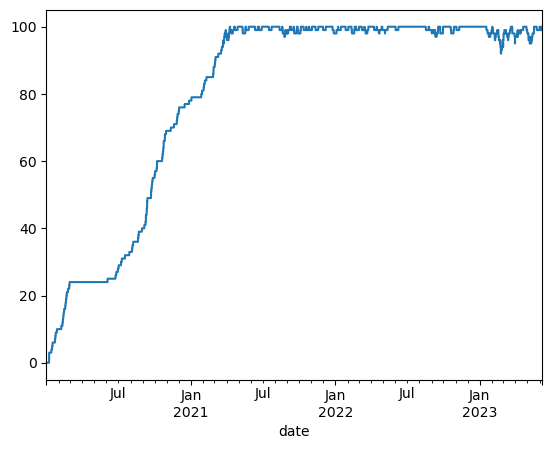

In [6]:
alldata.groupby('date')['inuniv'].sum().plot()

2021年之前universe不足50个symbol，不建议用作backtest

### alldata

In [8]:
alldata.head()

,date,open_time,open,high,low,close,volume,close_time,usdt_volume,num_trades,...,fperf_96,fperf_120,fperf_144,fperf_168,volume24,illiq24,zperf_seas30_vol,sfret_60m,alpha_bperf_24,tmp
0,2022-01-26 12:00:00,2022-01-26 11:00:00,0.002089,0.002100,0.001963,0.002047,87702423.0,2022-01-26 11:59:59.999,177124.500855,1211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-26 13:00:00,2022-01-26 12:00:00,0.002041,0.002090,0.001988,0.002067,178920633.0,2022-01-26 12:59:59.999,365741.164546,2810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-26 14:00:00,2022-01-26 13:00:00,0.002056,0.002079,0.001995,0.002035,189898479.0,2022-01-26 13:59:59.999,385718.454290,3695,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-26 15:00:00,2022-01-26 14:00:00,0.002043,0.002047,0.001995,0.002021,156743728.0,2022-01-26 14:59:59.999,315099.115658,2712,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-26 16:00:00,2022-01-26 15:00:00,0.002018,0.002045,0.002012,0.002027,94903857.0,2022-01-26 15:59:59.999,192204.649648,1863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
alldata.columns

Index(['date', 'open_time', 'open', 'high', 'low', 'close', 'volume',
       'close_time', 'usdt_volume', 'num_trades', 'buy_volume',
       'buy_usdt_volume', 'symbol', 'zperf', 'bperf_1', 'bperf_2', 'bperf_3',
       'bperf_5', 'bperf_12', 'bperf_24', 'bperf_48', 'bperf_168', 'ones',
       'vol', 'adv', 'inuniv', 'zperf_market', 'vwap_60m', 'vwap_30m',
       'vwap_20m', 'vwap_15m', 'vwap_10m', 'vwap_5m', 'close_1m', 'fret_1m',
       'fret_5m', 'fret_10m', 'fret_15m', 'fret_20m', 'fret_30m', 'fret_60m',
       'fperf_1', 'fperf_2', 'fperf_3', 'fperf_5', 'fperf_6', 'fperf_10',
       'fperf_12', 'fperf_15', 'fperf_20', 'fperf_24', 'fperf_48', 'fperf_72',
       'fperf_96', 'fperf_120', 'fperf_144', 'fperf_168', 'volume24',
       'illiq24', 'zperf_seas30_vol', 'sfret_60m', 'alpha_bperf_24', 'tmp'],
      dtype='object')

### Example

In [5]:
utility.gfun_df('alpha_bperf_24', alldata, 'tmp', 'date', lambda x: utility.rerank(x), tgt_arr=alldata['bperf_24']/alldata['vol'], cond=alldata.inuniv)

In [10]:
alldata['bperf_24_vol'] = alldata['bperf_24']/alldata['vol']
utility.cgma(alldata, cn=['cnt', 'vol', 'adv'], gb=utility.xrank(alldata['bperf_24_vol'], 10), rmod='fret', ofun_dict={}, ret_ds=[0,1,5,10,15,20,30,60])

,mygroup,cnt,vol,adv,med_bperf_24_vol,min_bperf_24_vol,max_bperf_24_vol,0,1,5,10,15,20,30,60
0,0.000000,"315,335",1.1%,"1,698,512",-760.8%,-2321.8%,-564.2%,0.040%,0.036%,0.038%,0.044%,0.048%,0.050%,0.055%,0.054%
1,1.000000,"315,335",1.1%,"1,926,303",-445.0%,-564.2%,-356.1%,0.006%,0.009%,0.011%,0.014%,0.015%,0.017%,0.019%,0.022%
2,2.000000,"315,334",1.2%,"2,021,422",-283.1%,-356.1%,-219.4%,-0.005%,-0.002%,-0.001%,0.000%,0.001%,0.001%,0.002%,0.007%
3,3.000000,"315,335",1.2%,"2,007,040",-161.3%,-219.4%,-107.2%,-0.000%,0.001%,0.003%,0.005%,0.007%,0.007%,0.008%,0.009%
4,4.000000,"315,334",1.1%,"1,953,597",-55.3%,-107.2%,-3.7%,0.005%,0.003%,0.004%,0.005%,0.005%,0.005%,0.004%,0.001%
5,5.000000,"315,335",1.1%,"1,782,401",44.0%,-3.7%,95.8%,0.008%,0.005%,0.005%,0.003%,0.002%,-0.000%,-0.002%,-0.007%
6,6.000000,"315,334",1.1%,"1,785,128",150.4%,95.8%,209.4%,0.004%,-0.001%,-0.003%,-0.004%,-0.006%,-0.006%,-0.008%,-0.012%
7,7.000000,"315,335",1.1%,"1,720,315",275.5%,209.4%,352.7%,0.000%,-0.001%,-0.003%,-0.005%,-0.006%,-0.006%,-0.007%,-0.010%
8,8.000000,"315,334",1.1%,"1,710,984",448.0%,352.7%,578.9%,0.002%,0.002%,-0.000%,-0.003%,-0.005%,-0.006%,-0.008%,-0.010%
9,9.000000,"315,335",1.1%,"1,974,309",794.8%,578.9%,11256.2%,-0.004%,0.003%,0.002%,-0.003%,-0.006%,-0.008%,-0.013%,-0.023%


从上述cgma中可以看出，我们应该选择60分钟去做成交。于是，我们以60分钟为基础去重新计算fperf：

In [13]:
alldata = utility.calcfperf_binance(alldata, 'fret_60m')

In [14]:
utility.cgma(alldata, cn=['cnt', 'vol', 'adv'], gb=utility.xrank(alldata['bperf_24_vol'], 10), rmod='fperf', ofun_dict={}, ret_ds=[0,1,2,3,5,6,10,12,24])

,mygroup,cnt,vol,adv,med_bperf_24_vol,min_bperf_24_vol,max_bperf_24_vol,0,1,2,3,5,6,10,12,24
0,0.000000,"315,335",1.1%,"1,698,512",-760.8%,-2321.8%,-564.2%,0.040%,0.035%,0.064%,0.093%,0.136%,0.170%,0.339%,0.378%,0.548%
1,1.000000,"315,335",1.1%,"1,926,303",-445.0%,-564.2%,-356.1%,0.006%,0.032%,0.068%,0.099%,0.152%,0.172%,0.262%,0.301%,0.414%
2,2.000000,"315,334",1.2%,"2,021,422",-283.1%,-356.1%,-219.4%,-0.005%,0.009%,0.018%,0.031%,0.055%,0.070%,0.093%,0.117%,0.156%
3,3.000000,"315,335",1.2%,"2,007,040",-161.3%,-219.4%,-107.2%,-0.000%,0.002%,0.006%,0.010%,0.009%,0.008%,-0.002%,0.009%,0.016%
4,4.000000,"315,334",1.1%,"1,953,597",-55.3%,-107.2%,-3.7%,0.005%,-0.005%,-0.012%,-0.020%,-0.034%,-0.040%,-0.080%,-0.081%,-0.116%
5,5.000000,"315,335",1.1%,"1,782,401",44.0%,-3.7%,95.8%,0.008%,-0.013%,-0.023%,-0.034%,-0.051%,-0.067%,-0.107%,-0.113%,-0.200%
6,6.000000,"315,334",1.1%,"1,785,128",150.4%,95.8%,209.4%,0.004%,-0.014%,-0.026%,-0.040%,-0.060%,-0.070%,-0.094%,-0.102%,-0.169%
7,7.000000,"315,335",1.1%,"1,720,315",275.5%,209.4%,352.7%,0.000%,-0.007%,-0.020%,-0.030%,-0.042%,-0.046%,-0.065%,-0.081%,-0.095%
8,8.000000,"315,334",1.1%,"1,710,984",448.0%,352.7%,578.9%,0.002%,-0.002%,-0.004%,-0.006%,-0.004%,-0.006%,-0.013%,-0.024%,0.061%
9,9.000000,"315,335",1.1%,"1,974,309",794.8%,578.9%,11256.2%,-0.004%,-0.006%,-0.009%,-0.011%,-0.006%,-0.004%,-0.018%,-0.025%,0.132%


return per trade会随着holding period的增长等倍率变大，但是曲线的平滑度却很可能会变差。

<AxesSubplot:xlabel='date'>

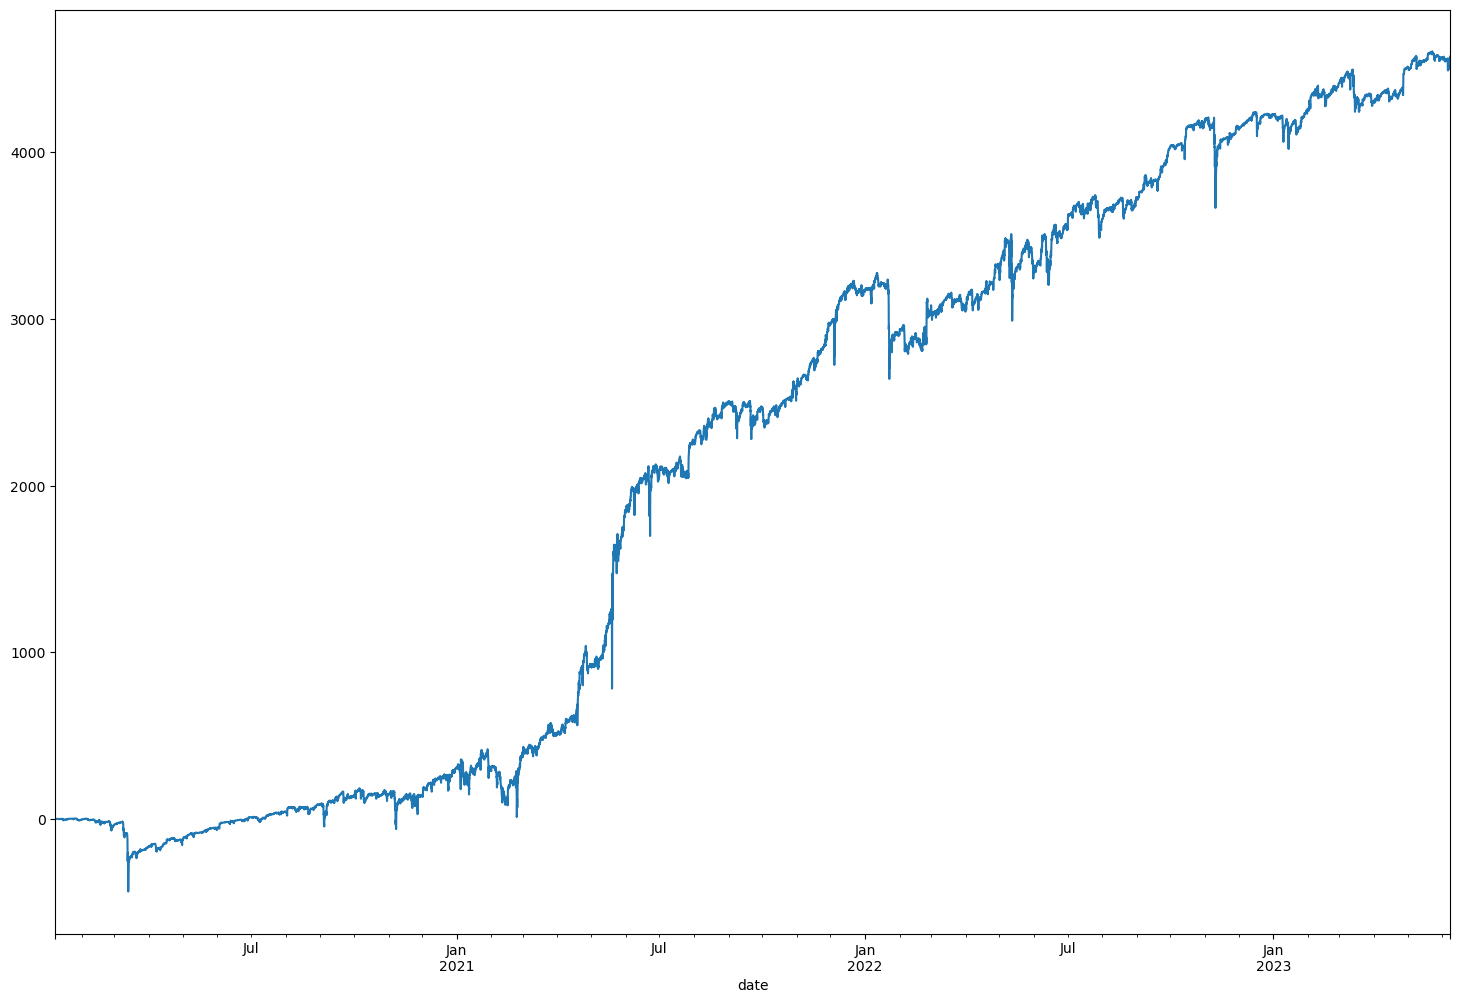

In [15]:
feature = 'bperf_24_vol'
tfilters = alldata.inuniv & (alldata[feature].abs()>0)
alldata[tfilters].groupby('date').apply(lambda x: (-x[feature]*(x['fret_60m']+x['fperf_1']).clip(-0.5,0.5)).sum()).cumsum().plot(figsize=(18,12))

<AxesSubplot:xlabel='date'>

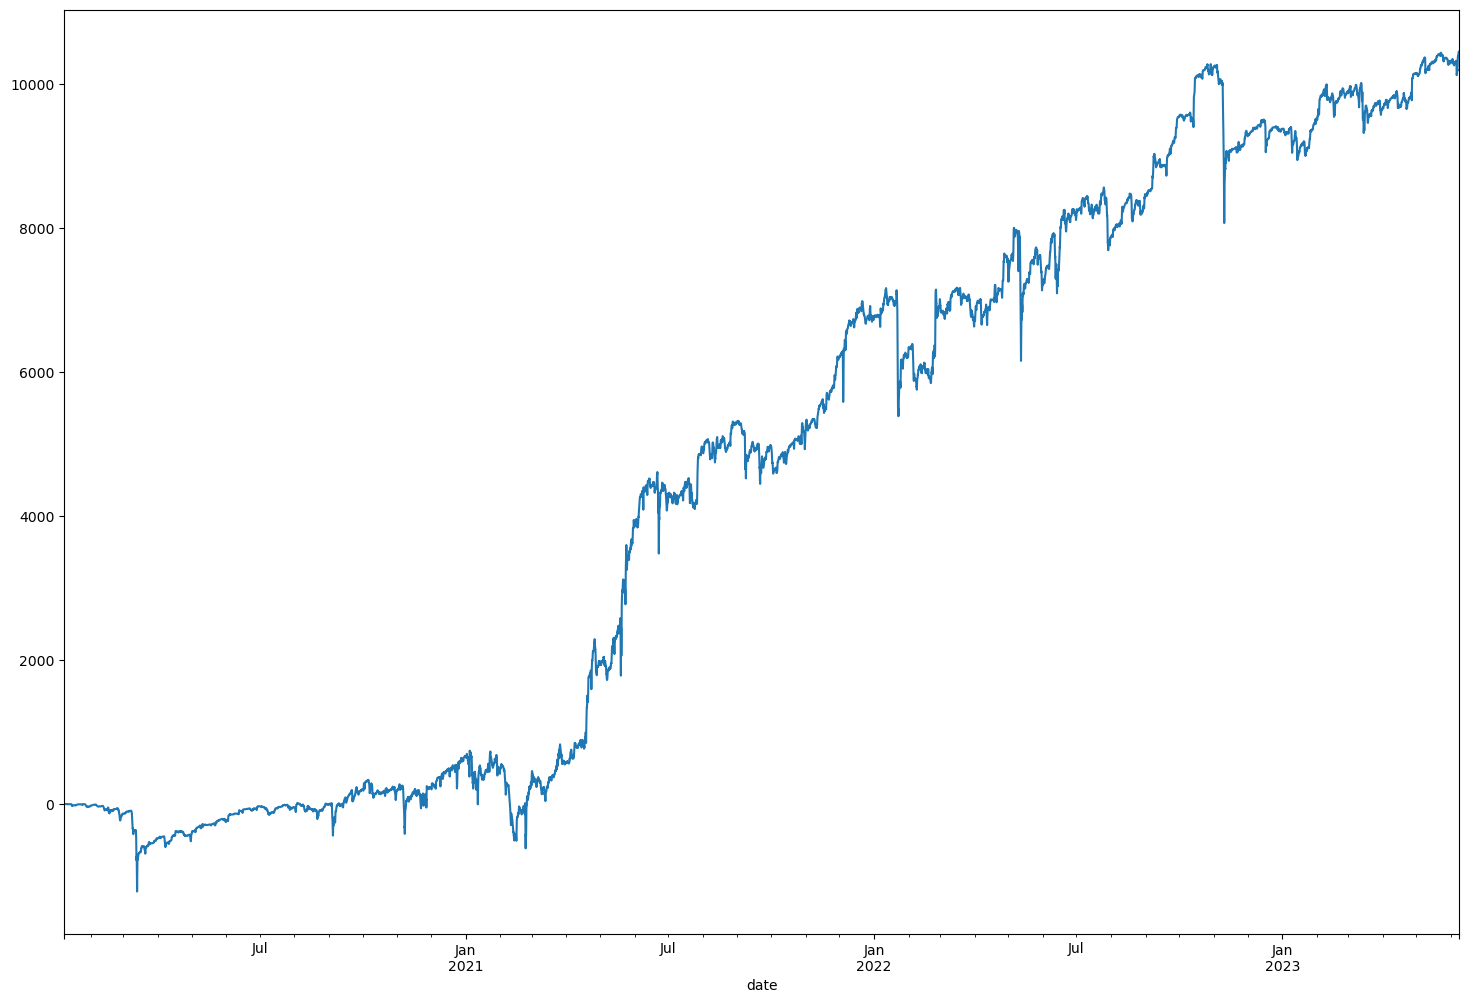

In [18]:
feature = 'bperf_24_vol'
tfilters = alldata.inuniv & (alldata[feature].abs()>0)
alldata[tfilters].groupby('date').apply(lambda x: (-x[feature]*(x['fret_60m']+x['fperf_6']).clip(-0.5,0.5)).sum()).cumsum().plot(figsize=(18,12))

<AxesSubplot:xlabel='date'>

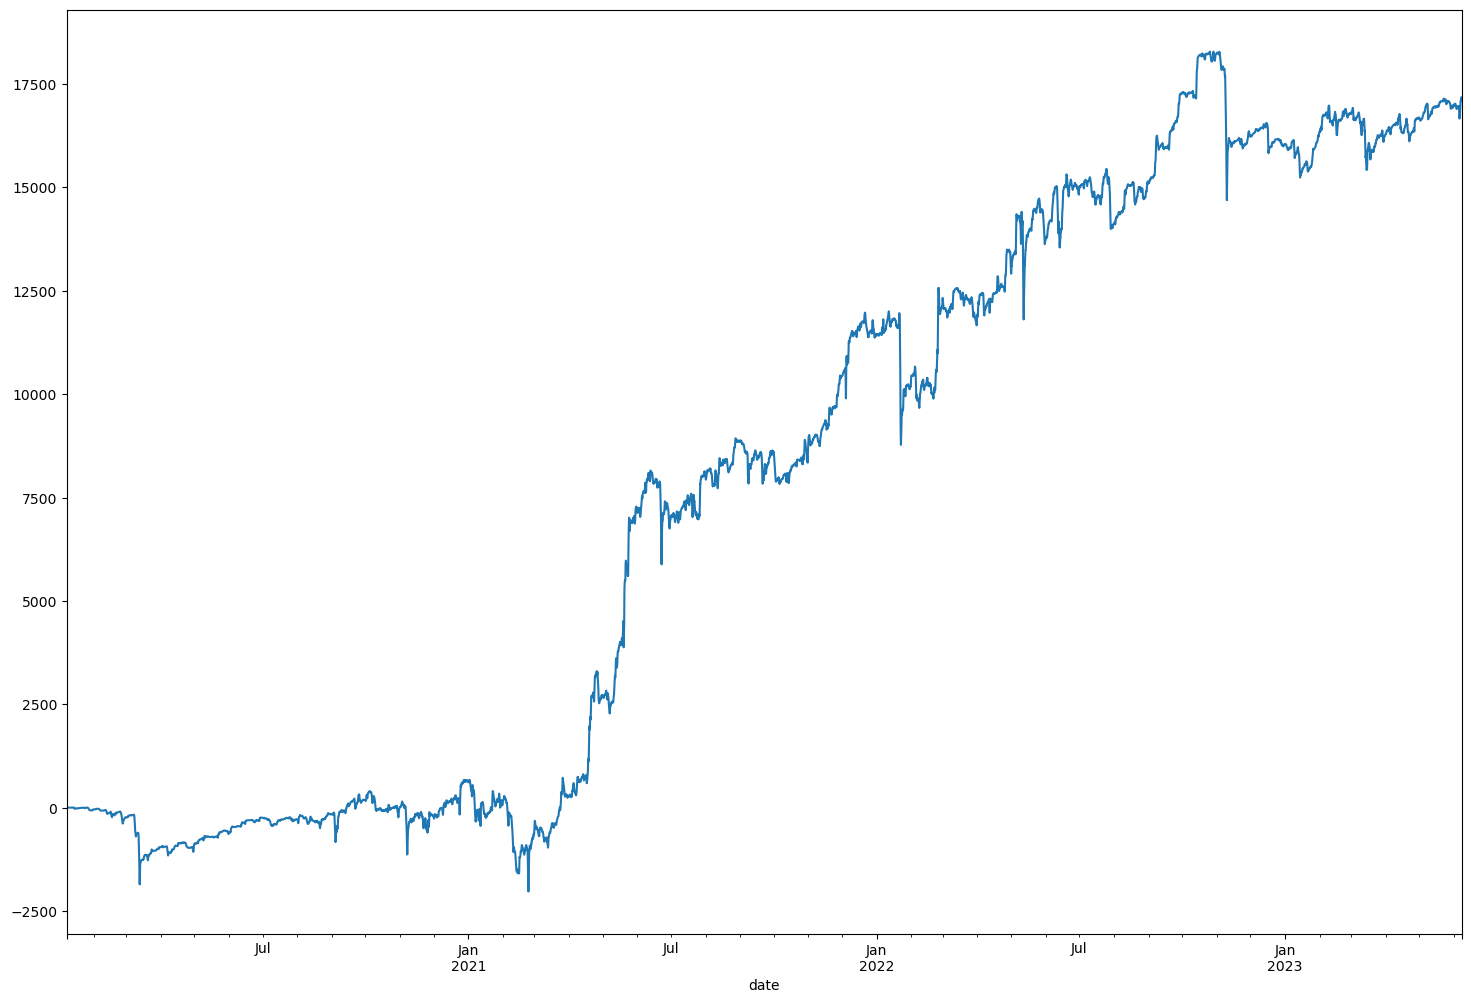

In [17]:
feature = 'bperf_24_vol'
tfilters = alldata.inuniv & (alldata[feature].abs()>0)
alldata[tfilters].groupby('date').apply(lambda x: (-x[feature]*(x['fret_60m']+x['fperf_12']).clip(-0.5,0.5)).sum()).cumsum().plot(figsize=(18,12))

In [28]:
alldata['sig_bperf_24_vol'] = (-1) * alldata['bperf_24_vol']
alldata['fperf_tgt'] = alldata['fret_60m'] + alldata['fperf_1']

In [30]:
alldata['abs_bperf_1_vol'] = np.abs(alldata['bperf_1'] / alldata['vol'])
feature = 'sig_bperf_24_vol'
utility.cgma(alldata, cn=['cnt', 'vol', 'adv'], gb=utility.xrank(alldata['abs_bperf_1_vol'], 10), rmod='fperf', cc=0.1, ofun_dict={}, ret_ds=[0,'tgt'], wtcol=feature, signcol=feature)

,mygroup,cnt,vol,adv,med_abs_bperf_1_vol,min_abs_bperf_1_vol,max_abs_bperf_1_vol,0,tgt
0,0.000000,"315,335",1.1%,"1,820,070",4.2%,0.0%,9.0%,0.010%,0.000242
1,1.000000,"315,335",1.1%,"1,936,623",13.8%,9.0%,18.6%,0.008%,0.000177
2,2.000000,"315,334",1.1%,"1,935,541",23.6%,18.6%,28.6%,0.009%,0.000404
3,3.000000,"315,335",1.1%,"1,923,722",33.9%,28.6%,39.4%,0.011%,0.000252
4,4.000000,"315,334",1.1%,"1,896,490",45.2%,39.4%,51.5%,0.012%,0.000305
5,5.000000,"315,335",1.1%,"1,871,112",58.2%,51.5%,65.6%,0.007%,0.000291
6,6.000000,"315,334",1.1%,"1,840,061",73.9%,65.6%,83.4%,0.009%,0.000439
7,7.000000,"315,335",1.1%,"1,793,310",94.5%,83.4%,108.4%,0.017%,0.000523
8,8.000000,"315,334",1.1%,"1,759,255",126.6%,108.4%,153.5%,0.026%,0.000716
9,9.000000,"315,335",1.1%,"1,760,479",203.4%,153.5%,1296.1%,0.065%,0.001813


In [27]:
alldata['abs_bperf_1_vol'] = np.abs(alldata['bperf_1'] / alldata['vol'])
feature = 'sig_bperf_24_vol'
utility.cgma(alldata, cn=['cnt', 'vol', 'adv'], gb=utility.xrank(alldata['abs_bperf_1_vol'], 10), rmod='fperf', cc=0.1, ofun_dict={}, ret_ds=[1,2,3,5,6], wtcol=feature, signcol=feature)

,mygroup,cnt,vol,adv,med_abs_bperf_1_vol,min_abs_bperf_1_vol,max_abs_bperf_1_vol,1,2,3,5,6
0,0.000000,"315,335",1.1%,"1,820,070",4.2%,0.0%,9.0%,0.012%,0.026%,0.049%,0.086%,0.098%
1,1.000000,"315,335",1.1%,"1,936,623",13.8%,9.0%,18.6%,0.014%,0.025%,0.048%,0.090%,0.106%
2,2.000000,"315,334",1.1%,"1,935,541",23.6%,18.6%,28.6%,0.025%,0.036%,0.057%,0.093%,0.105%
3,3.000000,"315,335",1.1%,"1,923,722",33.9%,28.6%,39.4%,0.010%,0.027%,0.052%,0.084%,0.100%
4,4.000000,"315,334",1.1%,"1,896,490",45.2%,39.4%,51.5%,0.013%,0.029%,0.049%,0.076%,0.100%
5,5.000000,"315,335",1.1%,"1,871,112",58.2%,51.5%,65.6%,0.014%,0.029%,0.052%,0.083%,0.100%
6,6.000000,"315,334",1.1%,"1,840,061",73.9%,65.6%,83.4%,0.017%,0.041%,0.074%,0.114%,0.135%
7,7.000000,"315,335",1.1%,"1,793,310",94.5%,83.4%,108.4%,0.011%,0.031%,0.051%,0.100%,0.121%
8,8.000000,"315,334",1.1%,"1,759,255",126.6%,108.4%,153.5%,0.015%,0.044%,0.064%,0.119%,0.144%
9,9.000000,"315,335",1.1%,"1,760,479",203.4%,153.5%,1296.1%,0.060%,0.129%,0.154%,0.181%,0.203%


470450


<AxesSubplot:xlabel='date'>

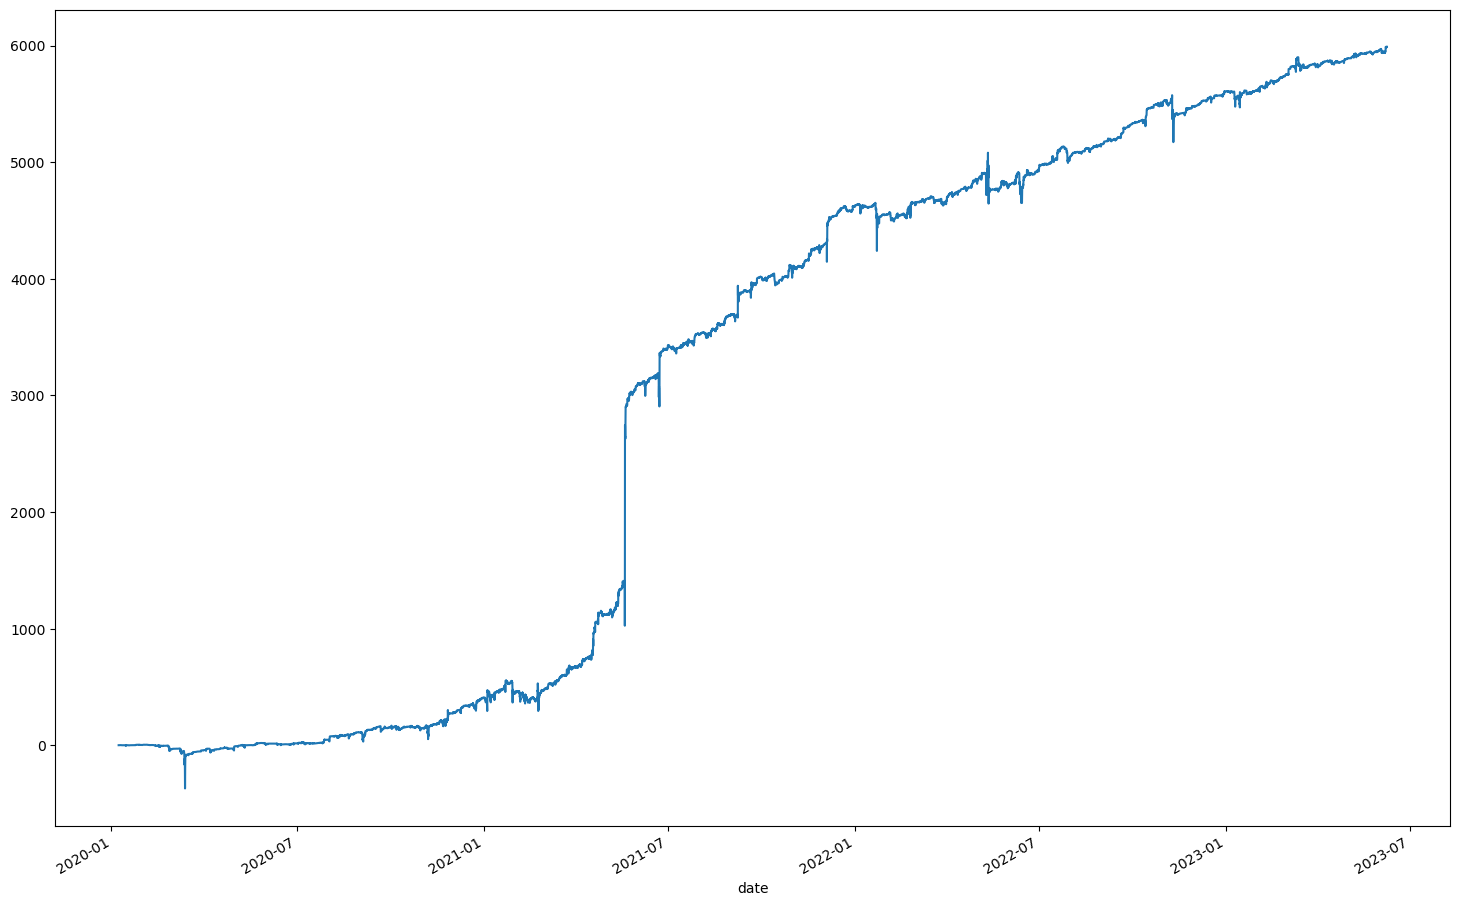

In [35]:
feature = 'sig_bperf_24_vol'
tfilters = alldata.inuniv & (alldata[feature].abs() > 1) & (alldata['abs_bperf_1_vol'] > 1)
print(sum(tfilters))
alldata[tfilters].groupby('date').apply(lambda x: (x[feature]*np.sqrt(x['abs_bperf_1_vol'].clip(1,10))*(x['fret_60m']+x['fperf_1']).clip(-0.5,0.5)).sum()).cumsum().plot(figsize=(18,12))

470450


<AxesSubplot:xlabel='date'>

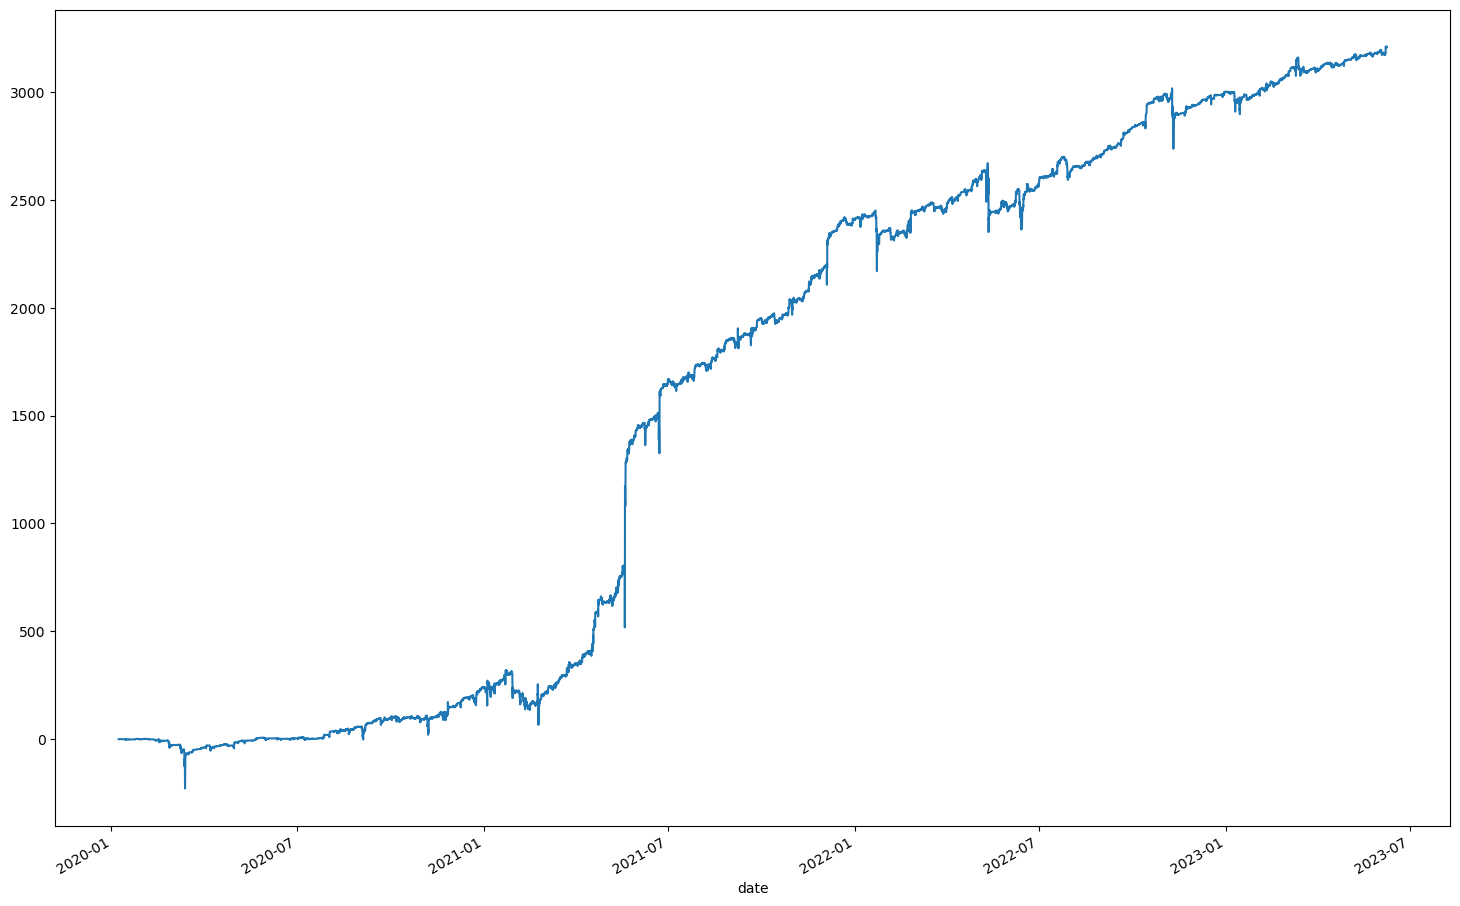

In [32]:
feature = 'sig_bperf_24_vol'
tfilters = alldata.inuniv & (alldata[feature].abs() > 1) & (alldata['abs_bperf_1_vol'] > 1)
print(sum(tfilters))
alldata[tfilters].groupby('date').apply(lambda x: (x[feature]*(x['fret_60m']+x['fperf_1']).clip(-0.5,0.5)).sum()).cumsum().plot(figsize=(18,12))

In [50]:
alldata['sig_bperf_24_vol_boost'] = alldata['sig_bperf_24_vol'] * (alldata['sig_bperf_24_vol'].abs() > 1) * (alldata['abs_bperf_1_vol'] > 1) * np.sqrt(alldata['abs_bperf_1_vol'].clip(1,10))
utility.gfun_df('sig1', alldata, 'sig_bperf_24_vol_boost', 'symbol', lambda x: x + x.shift(1))
alldata['sig1'] = alldata['sig1'] * alldata['inuniv']

avg positive weight: 164.10706785447599
avg negative weight: -146.9908741266584


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,266.52,0.81,-38.48,-38.48,5.80,-1.10,-1.10
2021Q2,294.11,0.88,220.46,220.46,59.47,4.98,4.98
2021Q3,265.21,0.87,77.31,77.31,13.89,3.11,3.11
2021Q4,283.98,0.83,62.82,62.82,13.04,2.42,2.42
2022Q1,299.18,0.91,10.59,10.59,0.85,0.51,0.51
2022Q2,292.59,0.91,139.86,139.86,6.31,4.01,4.01
2022Q3,232.98,0.95,162.58,162.58,9.41,8.44,8.44
2022Q4,266.16,0.90,138.34,138.34,6.08,6.45,6.45
2023Q1,263.05,0.90,33.41,33.41,5.24,1.59,1.59


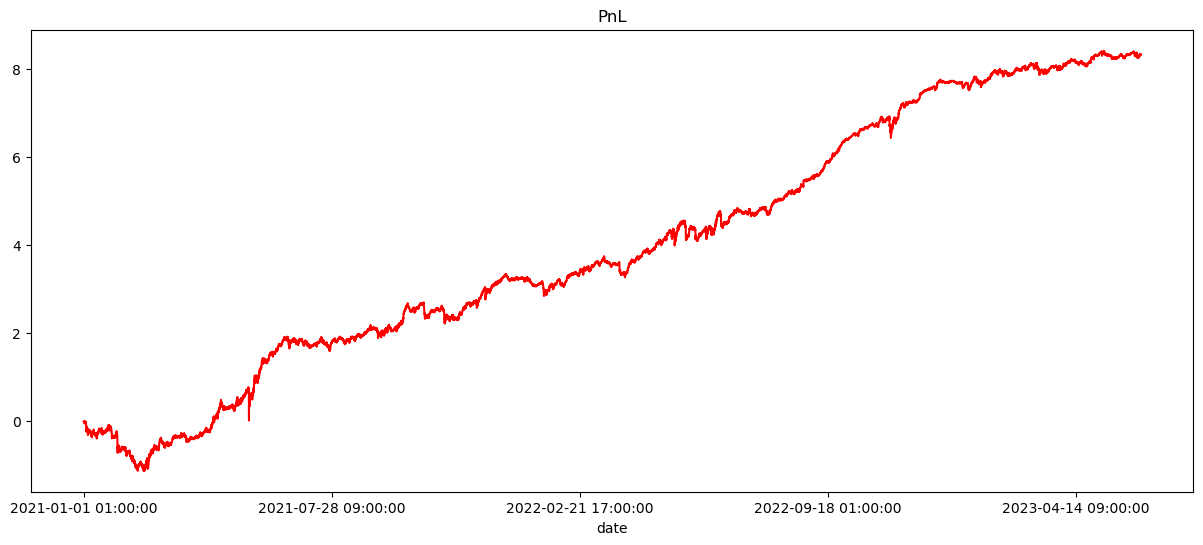

In [51]:
utility.pnldetails(alldata[alldata.date>'2021'], 'sig1', ret_col='fret_60m')

avg positive weight: 164.10706785447599
avg negative weight: -146.9908741266584


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,266.52,0.81,-38.48,-73.24,5.80,-1.10,-2.09
2021Q2,294.11,0.88,220.46,181.85,59.47,4.98,4.11
2021Q3,265.21,0.87,77.31,38.99,13.89,3.11,1.57
2021Q4,283.98,0.83,62.82,25.97,13.04,2.42,1.00
2022Q1,299.18,0.91,10.59,-28.58,0.85,0.51,-1.37
2022Q2,292.59,0.91,139.86,100.32,6.31,4.01,2.88
2022Q3,232.98,0.95,162.58,120.86,9.41,8.44,6.28
2022Q4,266.16,0.90,138.34,98.83,6.08,6.45,4.61
2023Q1,263.05,0.90,33.41,-5.44,5.24,1.59,-0.26


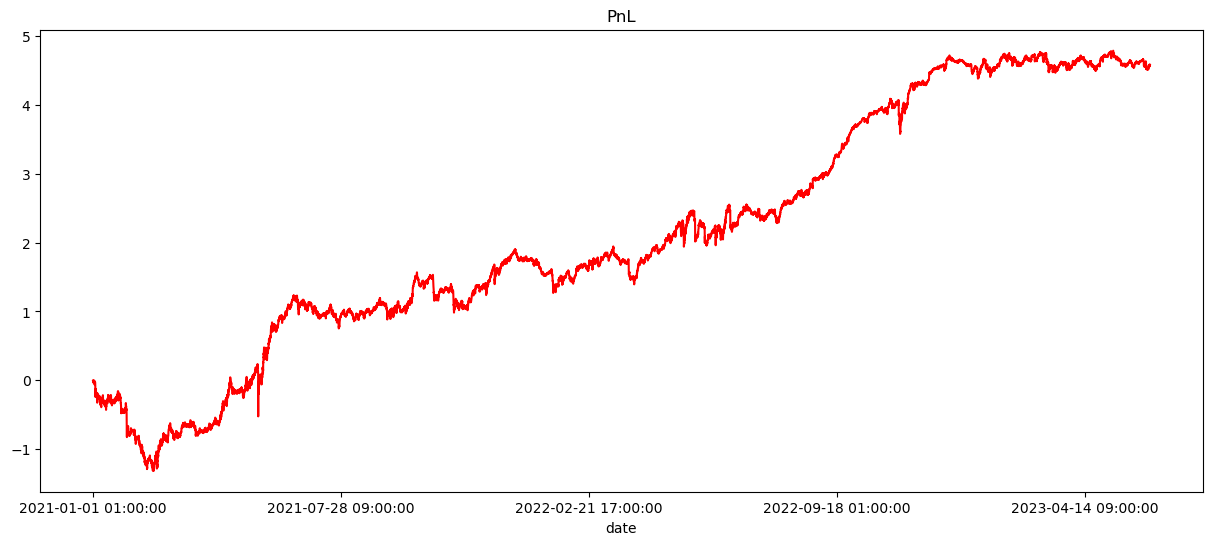

In [52]:
utility.pnldetails(alldata[alldata.date>'2021'], 'sig1', ret_col='fret_60m', tcost=2e-4)

In [53]:
utility.gfun_df('sig1_ma6', alldata, 'sig_bperf_24_vol_boost', 'symbol', lambda x: x.rolling(window=6).mean())
alldata['sig1_ma6'] = alldata['sig1_ma6'] * alldata['inuniv']

avg positive weight: 64.80196483292826
avg negative weight: -71.04114307721042


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,131.30,0.28,-80.99,-93.28,5.58,-2.52,-2.90
2021Q2,144.95,0.31,157.69,144.15,82.22,4.03,3.69
2021Q3,130.63,0.31,44.54,30.74,12.33,2.04,1.41
2021Q4,139.89,0.31,59.35,45.79,21.10,2.78,2.14
2022Q1,147.01,0.33,7.31,-7.04,3.12,0.42,-0.40
2022Q2,142.52,0.33,126.24,111.72,6.79,4.46,3.94
2022Q3,114.90,0.34,89.50,74.47,8.07,5.67,4.72
2022Q4,131.49,0.33,44.99,30.54,2.08,2.55,1.73
2023Q1,130.27,0.33,45.82,31.48,9.03,2.84,1.95


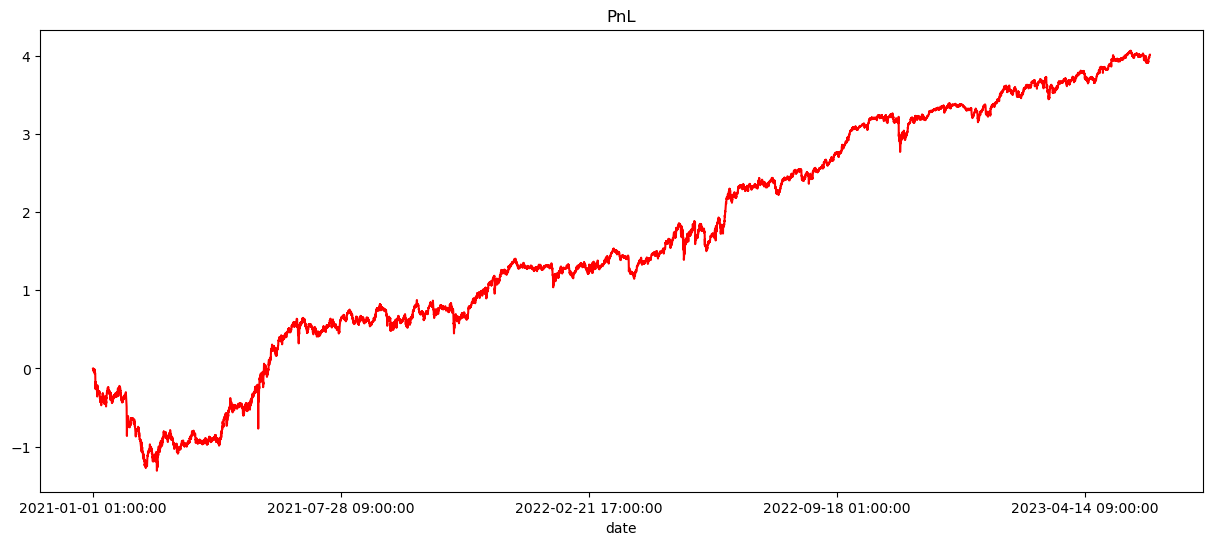

In [54]:
utility.pnldetails(alldata[alldata.date>'2021'], 'sig1_ma6', ret_col='fret_60m', tcost=2e-4)